In [ ]:
# Install necessary libraries
!pip install shap
!pip install xgboost
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install joblib

In [ ]:


# Import libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import shap
import time
import joblib
import warnings
import pickle
from urllib.request import urlopen
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Define constants in a dictionary
config = {
    'file_path': "https://raw.githubusercontent.com/Vaishnav8395/ReGenCast/main/SunPower_Full.csv",
    'target_variable': 'Active_Power',
    'predictors': ['temperature_2m', 'relativehumidity_2m', 'direct_radiation', 'diffuse_radiation',  'windspeed_10m', 'cloudcover', 'season'],
    'categorical_variables': ['season'],
    'time_intervals': ['first_interval','second_interval','third_interval','fourth_interval','fifth_interval','sixth_interval'],
    'weather_types': ['TypeA', 'TypeB', 'TypeC'],
    'standardize_predictor_list': ['temperature_2m', 'relativehumidity_2m', 'direct_radiation', 'diffuse_radiation',  'windspeed_10m', 'cloudcover']
}

# Load data
def load_data(file_path):
    df = pd.read_csv(file_path, sep = '\t')
    df.rename(columns = {'timestamp':'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df[config['target_variable']] = df[config['target_variable']].clip(lower=0)   #set negative values to 0
    return df

# Add season
def add_season(df):
    def season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'fall'
    df['season'] = df['date'].dt.month.apply(season)
    return df

# Choose only 7-18 interval
def choose_interval(df):
    df = df.sort_values('date')
    df = df.set_index('date')
    df = df.between_time('07:00', '18:00')
    return df

# Split data
def split_data(df):
    ord_enc = OrdinalEncoder()
    season = ord_enc.fit_transform(np.array(df['season']).reshape(-1,1))
    df['season'] = season
    cutoff_date = df.index.min() + pd.DateOffset(years=7)
    train = df.loc[:cutoff_date]
    test = df.loc[cutoff_date+ pd.DateOffset(hours=1):]
    return train, test

# Detect time interval
def detect_time_interval(df):
    df_time_detect = df.copy()
    intervals = {'first_interval': (7, 9), 'second_interval': (9, 11), 'third_interval': (11, 13),
                'fourth_interval': (13, 15), 'fifth_interval': (15, 17), 'sixth_interval': (17, 18)}
    df_time_detect['time_interval'] = pd.cut(df_time_detect.index.hour, bins=[interval[0] for interval in intervals.values()] + [24],
                                labels=[interval_name for interval_name in intervals.keys()],
                                include_lowest=True, right=False)
    return df_time_detect

# Create weather type
def create_weather_type(train):
    new_train = pd.DataFrame()
    for interval in config['time_intervals']:
        train_df = train[train['time_interval'] == interval].copy()
        weather_type = []
        avg_kwh = np.mean(train_df[config['target_variable']])
        max_kwh = max(train_df[config['target_variable']])
        min_kwh = min(train_df[config['target_variable']])
        for y in train_df[config['target_variable']]:
            if (y >= avg_kwh):
                weather_type.append("TypeA")
            elif (y > avg_kwh - (avg_kwh - min_kwh) / 2 ) and (y <  avg_kwh):
                weather_type.append("TypeB")
            elif (y >= 0) and (y<= avg_kwh - (avg_kwh - min_kwh)/2):
                weather_type.append("TypeC")
            else:
                raise ValueError(f"Something wrong happened in weather type classification for {interval}")
        train_df['weather_type'] = weather_type
        new_train = pd.concat([new_train, train_df])
    new_train = new_train.sort_index()
    return new_train

# Train random forest classifier
def train_rf_classifier(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(rfc, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    return grid_search

# Predict weather type
def predict_weather_type(grid_search, X_test):
    y_pred = grid_search.best_estimator_.predict(X_test)
    X_test.loc[:,'weather_type'] = y_pred
    return X_test

# Classify weather type
def classify_weather_type(new_train, test):
    new_test = pd.DataFrame()
    for interval in config['time_intervals']:
        interval_train_dataset = new_train[new_train['time_interval'] == interval].copy()
        interval_test_dataset = test[test['time_interval'] == interval].copy()
        try:
            grid = joblib.load(urlopen(f'https://raw.githubusercontent.com/Vaishnav8395/ReGenCast/master/ClassifiedWeatherTypes/RF_Weather_{interval}_.pkl'))
            classified_weather_type = predict_weather_type(grid, interval_test_dataset[config['predictors']].copy())
        except:
            grid = train_rf_classifier(interval_train_dataset[config['predictors']] , interval_train_dataset['weather_type'])
            joblib.dump(grid, f'RF_Weather_{interval}_.pkl') #save fitted model
            classified_weather_type = predict_weather_type(grid, interval_test_dataset[config['predictors']].copy())
        classified_weather_type['time_interval'] = interval
        print(f"Weather type Predictions done for {interval}")
        new_test = pd.concat([new_test, classified_weather_type])
    new_test = new_test.sort_index()
    return new_test

# Standardize data
def standardize_data(new_train, new_test):
    X_new_train = new_train[config['standardize_predictor_list']]
    X_new_test = new_test[config['standardize_predictor_list']]
    predictor_scaler = StandardScaler()
    predictor_scaler_fit = predictor_scaler.fit(X_new_train)
    X_new_train= predictor_scaler_fit.transform(X_new_train)
    X_new_test = predictor_scaler_fit.transform(X_new_test)
    new_stand_train = pd.DataFrame(X_new_train, index=new_train[config['standardize_predictor_list']].index, columns=new_train[config['standardize_predictor_list']].columns)
    new_stand_test = pd.DataFrame(X_new_test, index=new_test[config['standardize_predictor_list']].index, columns=new_test[config['standardize_predictor_list']].columns)
    new_stand_train = pd.concat([new_stand_train, new_train[['season', config['target_variable'], 'weather_type', 'time_interval']]], axis = 1)
    new_stand_test = pd.concat([new_stand_test, new_test[['season','weather_type', 'time_interval']]], axis = 1)
    return new_stand_train, new_stand_test

# Train Random Forest Regressor
def train_RF_regressor(X_train, y_train):
    param_grid = {
         'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(
        estimator= RandomForestRegressor(),
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=10,
    )
    grid_search.fit(X_train, y_train)
    return grid_search

# Train and predict using Random Forest model
def train_predict_RF_model(new_stand_train, new_stand_test):
    forecast_test = pd.DataFrame()
    for interval, weather_type in product(config['time_intervals'], config['weather_types']):
        X_train = new_stand_train[(new_stand_train['time_interval'] == interval) & (new_stand_train['weather_type'] == weather_type)][config['predictors']]
        y_train = new_stand_train[(new_stand_train['time_interval'] == interval) & (new_stand_train['weather_type'] == weather_type)][config['target_variable']]
        X_test = new_stand_test[(new_stand_test['time_interval'] == interval) & (new_stand_test['weather_type'] == weather_type)][config['predictors']]
        try:
            md = joblib.load(urlopen(f'https://raw.githubusercontent.com/Vaishnav8395/ReGenCast/master/Fitted_Models/RF_fitted_{interval}_{weather_type}.pkl'))
            predictions = md.predict(X_test)
        except:
            md = train_RF_regressor(X_train, y_train)
            joblib.dump(md, f'RF_fitted_{interval}_{weather_type}.pkl') #save fitted model
            predictions = md.predict(X_test)

        print(f"Energy Predictions done for {interval, weather_type}")
        TestingData=pd.DataFrame(data=X_test.copy(), columns=X_test.columns)
        TestingData['PredictedTotalPower']=predictions
        forecast_test = pd.concat([forecast_test, TestingData])
    forecast_test = forecast_test.sort_index()
    return forecast_test

# SMAPE
def smape(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Evaluate model
def evaluate_model(forecast_test, test,new_test):
    y_test = test.loc[new_test.index, config['target_variable']]
    forecast_test['ActualTotalPower']= y_test
    #set negative values at 0
    forecast_test['PredictedTotalPower'] = forecast_test['PredictedTotalPower'].clip(lower=0)

    mae = metrics.mean_absolute_error(forecast_test['ActualTotalPower'], forecast_test['PredictedTotalPower'])
    mse = metrics.mean_squared_error(forecast_test['ActualTotalPower'], forecast_test['PredictedTotalPower'])
    mape = metrics.mean_absolute_percentage_error(forecast_test['ActualTotalPower'], forecast_test['PredictedTotalPower'])
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(forecast_test['ActualTotalPower'],forecast_test['PredictedTotalPower'])
    smape_ = smape(forecast_test['ActualTotalPower'], forecast_test['PredictedTotalPower'])
    print("Results of sklearn.metrics:")
    print("MAE:",round(mae,3))
    print("RMSE:", round(rmse,3))
    print(f"R-Squared: {round(r2,3) * 100} %")
    print(f"Scaled mean absolute percentage error: {round(smape_,3)} %")
    return mae,rmse,r2,smape_

# Main function
def main():
    df = load_data(config['file_path'])
    df = add_season(df)
    df = choose_interval(df)
    train, test = split_data(df)
    train = detect_time_interval(train)
    test = detect_time_interval(test)
    new_train_data = create_weather_type(train)
    new_test_data = classify_weather_type(new_train_data, test)
    new_stand_train, new_stand_test = standardize_data(new_train_data, new_test_data)
    forecasted_data_RF = train_predict_RF_model(new_stand_train, new_stand_test)
    evaluate_model(forecasted_data_RF, test, new_test_data)

# Run the main function
if __name__ == "__main__":
    main()

Weather type Predictions done for first_interval
Weather type Predictions done for second_interval
Weather type Predictions done for third_interval
Weather type Predictions done for fourth_interval
Weather type Predictions done for fifth_interval
Weather type Predictions done for sixth_interval
Energy Predictions done for ('first_interval', 'TypeA')
Energy Predictions done for ('first_interval', 'TypeB')
Energy Predictions done for ('first_interval', 'TypeC')
Energy Predictions done for ('second_interval', 'TypeA')
Energy Predictions done for ('second_interval', 'TypeB')
Energy Predictions done for ('second_interval', 'TypeC')
Energy Predictions done for ('third_interval', 'TypeA')
Energy Predictions done for ('third_interval', 'TypeB')
Energy Predictions done for ('third_interval', 'TypeC')
Energy Predictions done for ('fourth_interval', 'TypeA')
Energy Predictions done for ('fourth_interval', 'TypeB')
Energy Predictions done for ('fourth_interval', 'TypeC')
Energy Predictions done fo

Weather type Predictions done for first_interval
Weather type Predictions done for second_interval
Weather type Predictions done for third_interval
Weather type Predictions done for fourth_interval
Weather type Predictions done for fifth_interval
Weather type Predictions done for sixth_interval
Energy Predictions done for ('first_interval', 'TypeA')
Energy Predictions done for ('first_interval', 'TypeB')
Energy Predictions done for ('first_interval', 'TypeC')
Energy Predictions done for ('second_interval', 'TypeA')
Energy Predictions done for ('second_interval', 'TypeB')
Energy Predictions done for ('second_interval', 'TypeC')
Energy Predictions done for ('third_interval', 'TypeA')
Energy Predictions done for ('third_interval', 'TypeB')
Energy Predictions done for ('third_interval', 'TypeC')
Energy Predictions done for ('fourth_interval', 'TypeA')
Energy Predictions done for ('fourth_interval', 'TypeB')
Energy Predictions done for ('fourth_interval', 'TypeC')
Energy Predictions done fo

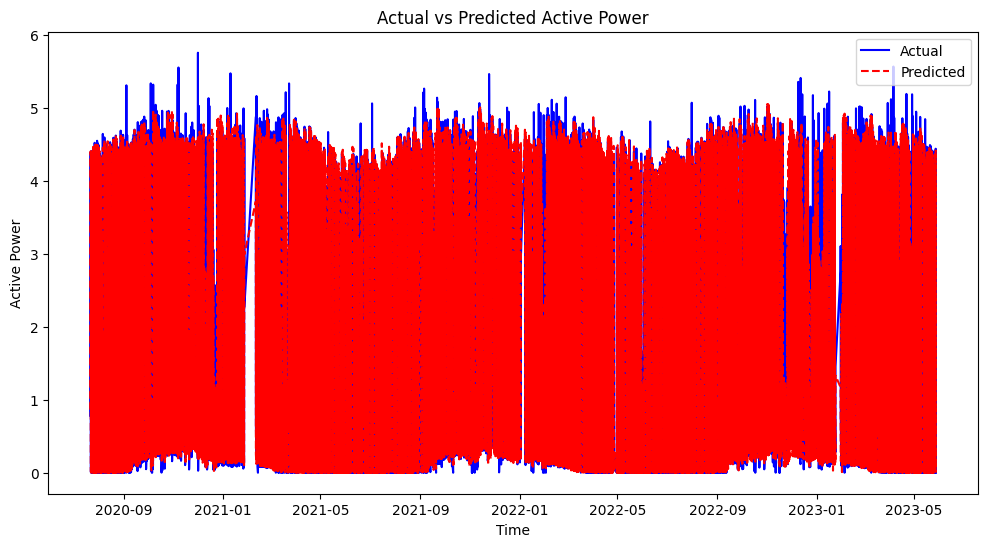

In [ ]:
# Main function to test the model
def main():
    # Step 1: Load and preprocess the data
    df = load_data(config['file_path'])
    df = add_season(df)
    df = choose_interval(df)
    train, test = split_data(df)
    train = detect_time_interval(train)
    test = detect_time_interval(test)

    # Step 2: Create weather types and classify them
    new_train_data = create_weather_type(train)
    new_test_data = classify_weather_type(new_train_data, test)

    # Step 3: Standardize the data
    new_stand_train, new_stand_test = standardize_data(new_train_data, new_test_data)

    # Step 4: Train and predict using the Random Forest model
    forecasted_data_RF = train_predict_RF_model(new_stand_train, new_stand_test)

    # Step 5: Evaluate the model
    evaluate_model(forecasted_data_RF, test, new_test_data)

    # Return the forecasted data for plotting
    return forecasted_data_RF

# Run the main function and get the forecasted data
forecasted_data_RF = main()

# Call the plotting function
plot_predictions(forecasted_data_RF)

In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from joblib import load
from urllib.request import urlopen


def manual_test():
    # Manually input test values
    test_input = {
        'temperature_2m': [25],  # Example temperature in Celsius
        'relativehumidity_2m': [100],  # Relative humidity in percentage
        'direct_radiation': [800],  # Direct radiation in W/m^2
        'diffuse_radiation': [200],  # Diffuse radiation in W/m^2
        'windspeed_10m': [5],  # Wind speed in m/s
        'cloudcover': [10],  # Cloud cover in percentage
        'season': [2],  # Encoded season (categorical, skip scaling)
        'time_interval': ['first_interval'],  # Time interval
        'weather_type': ['TypeA'],  # Weather type
    }

    # Convert input to DataFrame
    test_df = pd.DataFrame(test_input)

    # Load StandardScaler from remote URL
    standard_scaler_url = (
        'https://raw.githubusercontent.com/Vaishnav8395/ReGenCast/master/Fitted_Standardizers/std_scaler.bin'
    )
    try:
        standard_scaler = load(urlopen(standard_scaler_url))
    except Exception as e:
        print(f"Error loading the scaler: {e}")
        return

    # List of continuous predictors to be standardized (excluding 'season')
    continuous_features = [
        'temperature_2m', 'relativehumidity_2m', 'direct_radiation',
        'diffuse_radiation', 'windspeed_10m', 'cloudcover'
    ]

    # Standardize continuous predictors only
    try:
        test_df_standardized = test_df.copy()
        test_df_standardized[continuous_features] = standard_scaler.transform(test_df[continuous_features])
    except Exception as e:
        print(f"Error during data standardization: {e}")
        return

    # Load the model from remote URL
    interval = test_input['time_interval'][0]
    weather_type = test_input['weather_type'][0]
    model_url = (
        f'https://raw.githubusercontent.com/Vaishnav8395/ReGenCast/master/Fitted_Models/'
        f'RF_fitted_{interval}_{weather_type}.pkl'
    )
    try:
        model = load(urlopen(model_url))
    except Exception as e:
        print(f"Error loading model for {interval} and {weather_type}: {e}")
        return

    # Predict active power
    try:
        prediction = model.predict(test_df_standardized[continuous_features + ['season']])
        print(f"Predicted Active Power: {prediction[0]:.2f} kWh")
    except Exception as e:
        print(f"Error during prediction: {e}")


# Run the test function
manual_test()


Predicted Active Power: 1.80 kWh
